# Lab 5 - Regression and Dimensionality Reduction

**Student ID:** 17210577 <br>
**Student Name:** Lena Stolz

In [ ]:
# Import required packages
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA 
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import RFE
from sklearn import svm
from sklearn import cluster
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NeighborhoodComponentsAnalysis

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### I. Load the dataset + EDA (Exploratory Data Analysis)

In [ ]:
dataFrame = pd.read_csv("./insurance.csv")
dataFrame.head()

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075


In [ ]:
dataFrame.tail()

,age,gender,bmi,children,smoker,region,insurance_cost
1333,64,female,31.825,2,no,northeast,16069.08475
1334,64,female,26.885,0,yes,northwest,29330.98315
1335,64,male,26.410,0,no,northeast,14394.55790
1336,64,male,36.960,2,yes,southeast,49577.66240
1337,64,male,23.760,0,yes,southeast,26926.51440


In [ ]:
dataFrame['insurance_cost'].value_counts()

1639.56310     2
1725.55230     1
42211.13820    1
11033.66170    1
23568.27200    1
              ..
4949.75870     1
38711.00000    1
3756.62160     1
18765.87545    1
26926.51440    1
Name: insurance_cost, Length: 1337, dtype: int64

In [ ]:
dataFrame.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

In [ ]:
dataFrame.describe()

,age,bmi,children,insurance_cost
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


As we can see this dataset has no missing values nor does it contain errors or negative values.

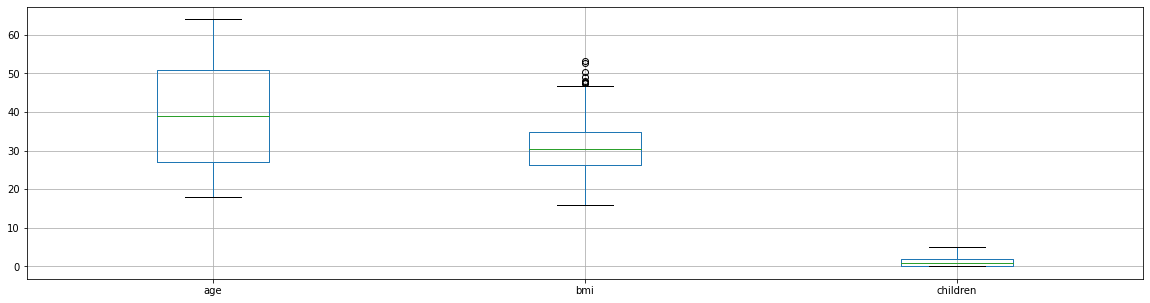

In [ ]:
dataFrame.drop('insurance_cost', axis = 1).boxplot(figsize = (20,5))
plt.show()

This box plot gives us som information:


*   `age` and `children` don't contain outliers
*   `bmi` contains outliers



### II. Data Preparation

First we will use one hot encodingreplace to replace `gender`, `smoker` and `region` , as these categorical attributes are not ordinal

In [ ]:
dataFrame = pd.get_dummies(dataFrame, columns = ['gender','smoker','region'], drop_first=True)

In [ ]:
dataFrame.head()

,age,bmi,children,insurance_cost,gender_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,18,33.770,1,1725.55230,1,0,0,1,0
1,18,34.100,0,1137.01100,1,0,0,1,0
2,18,26.315,0,2198.18985,0,0,0,0,0
3,18,38.665,2,3393.35635,0,0,0,0,0
4,18,35.625,0,2211.13075,0,0,0,0,0


In [ ]:
dataFrame.tail()

,age,bmi,children,insurance_cost,gender_male,smoker_yes,region_northwest,region_southeast,region_southwest
1333,64,31.825,2,16069.08475,0,0,0,0,0
1334,64,26.885,0,29330.98315,0,1,1,0,0
1335,64,26.410,0,14394.55790,1,0,0,0,0
1336,64,36.960,2,49577.66240,1,1,0,1,0
1337,64,23.760,0,26926.51440,1,1,0,1,0


Next we create a list from the outlier attributes and a list for the other columns.

In [ ]:
# store a list with the names of all predictors
names_all = [c for c in dataFrame if c not in ['insurance_cost']]

# define column groups with same data preparation
names_outliers = ['bmi']
names_no_outliers = list(set(names_all) - set(names_outliers))

In [ ]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y = None):
        return self

    def transform(self, X):
        return pd.DataFrame(data = X, columns = self.columns)

In [ ]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y = None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [ ]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns = names_all),
    FeatureUnion(transformer_list = [
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns = names_outliers),
            FunctionTransformer(np.log, validate = True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns = names_no_outliers),
            StandardScaler()
        ))
    ])
)

Next we split `insurance_cost` into test and training sets. We will us a 80/20 split.

In [ ]:
y = dataFrame['insurance_cost']
X = dataFrame.drop('insurance_cost', axis = 1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

### III.I Random Forest Pipeline

In [ ]:
pipe = Pipeline(steps = [('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators = 10))])

In [ ]:
N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power = 7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel = 'linear', gamma = 'auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [NeighborhoodComponentsAnalysis(random_state = 0)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
    }, 
    {
        'reduce_dim': [cluster.FeatureAgglomeration()],
        'reduce_dim__n_clusters': N_FEATURES_OPTIONS,
    }
    
]

search = GridSearchCV(pipe, param_grid, n_jobs = -1, cv = 5, refit = True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

### III.II LinearRefression Pipeline

In [ ]:
pipe = Pipeline(steps = [('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

In [ ]:
N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power = 7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel = 'linear', gamma = 'auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [NeighborhoodComponentsAnalysis(random_state = 0)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
    }, 
    {
        'reduce_dim': [cluster.FeatureAgglomeration()],
        'reduce_dim__n_clusters': N_FEATURES_OPTIONS,
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs = -1, cv = 5, refit = True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

### III.III K Neighbours Pipeline

In [ ]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', KNeighborsRegressor())])

In [ ]:
N_FEATURES_OPTIONS = [2, 6, 11]
NEIGHBOURS = [2, 3, 4, 5, 6, 7, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power = 7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__n_neighbors': NEIGHBOURS,
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel = 'linear', gamma = 'auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__n_neighbors': NEIGHBOURS,
    },
    {
        'reduce_dim': [NeighborhoodComponentsAnalysis(random_state = 0)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
    }, 
    {
        'reduce_dim': [cluster.FeatureAgglomeration()],
        'reduce_dim__n_clusters': N_FEATURES_OPTIONS,
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs = -1, cv = 5, refit = True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
KNR_best_params = search.best_params_
KNR_best_model = search.best_estimator_

### IV. Compare Regression Models on Test Set

In [ ]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

In [ ]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
KNR_mse, KNR_mae, KNR_r2 = evaluate_model(X_test, y_test, KNR_best_model)

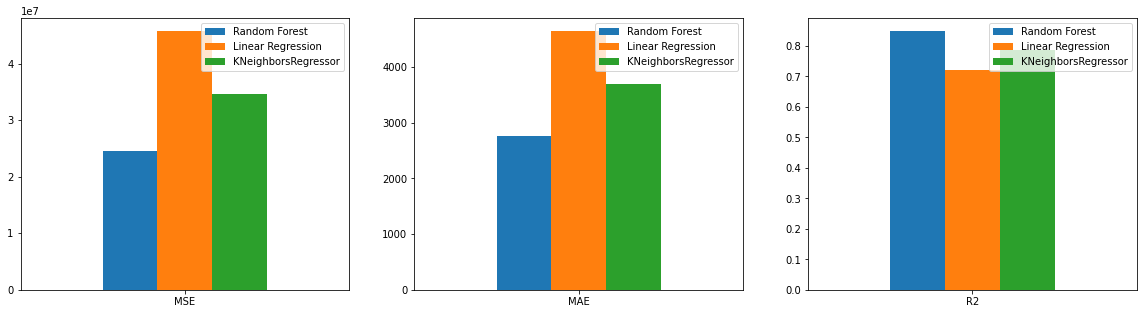

In [ ]:
dataFrame_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 
                              'KNeighborsRegressor': KNR_mse}, index = ['MSE'])
dataFrame_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 
                              'KNeighborsRegressor': KNR_mae}, index = ['MAE'])
dataFrame_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 
                             'KNeighborsRegressor': KNR_r2}, index = ['R2'])

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 5))

dataFrame_mse.plot.bar(rot = 0, ax = axes[0])
dataFrame_mae.plot.bar(rot = 0, ax = axes[1])
dataFrame_r2.plot.bar(rot = 0, ax = axes[2])

plt.show()

The followong conclusion can be drawn from the graphs:


*   `Random Forrest` is the better regression model. It has much slower MSE and MAE but higher R2 compare to the other models.
*   The second best model is `KNR`, as it has only a slightly lower in R2 compared to the previously evaluated model.
*   `Linear Regression` has the lowest R2, MSE and MAE and is therefore the worst performing model in this situation.

In conclusion: `Random Forest` is the best model we can choose for training purposes.






### V. Train Final Model

In the last section we train our Random Forest regression with the data we have. After that we save the results.

In [ ]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators = 10, **transform(RF_best_params, 'regresson__')))

final_model = pipe.fit(X, y)

In [ ]:
filename = 'finalModel.sav'
pickle.dump(final_model, open(filename, 'wb'))